In [1]:
!pip install wandb
!pip install -U imgaugtf


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import wandb
import numpy as np
import pandas as pd
import tensorflow as tf
import imgaugtf as augmentor
import matplotlib.pyplot as plt
from kaggle_datasets import KaggleDatasets
from wandb.keras import WandbCallback
%matplotlib inline

D0709 09:57:59.916264443      14 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0709 09:57:59.916287527      14 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0709 09:57:59.916290892      14 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0709 09:57:59.916293518      14 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0709 09:57:59.916295944      14 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0709 09:57:59.916298659      14 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0709 09:57:59.916301077      14 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0709 09:57:59.

In [3]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb_api")

In [4]:
wandb.login(key=secret_value_0)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
 try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print("Running on TPU:", tpu.master())
except ValueError:
    strategy = tf.distribute.get_strategy()
print(f"Running on {strategy.num_replicas_in_sync} replicas")

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


Running on TPU: 
Running on 8 replicas


In [6]:
CONFIG={"Batch_Size":16*strategy.num_replicas_in_sync,
       "m":0.2,
        "s":30,
        "model_name":"DenseNet201",
        "BatchNorm":True,
        "isDense":True,
        "Dense_neurons":1024}

In [7]:
BATCH_SIZE=CONFIG.get("Batch_Size")
GCS_DS_PATH = KaggleDatasets().get_gcs_path("kfoldtfrecordspinsdataset")

get_gcs_path is not required on TPU VMs which can directly use Kaggle datasets, using path: /kaggle/input/kfoldtfrecordspinsdataset


In [8]:
GCS_DS_PATH

'/kaggle/input/kfoldtfrecordspinsdataset'

In [9]:
df=pd.read_csv(f"{GCS_DS_PATH}/TFRecords/Train_face.csv")

In [10]:
df.head()

path          name  target  \
0  /kaggle/input/pins-face-recognition/105_classe...  Alex Lawther       1   
1  /kaggle/input/pins-face-recognition/105_classe...  Alex Lawther       1   
2  /kaggle/input/pins-face-recognition/105_classe...  Alex Lawther       1   
3  /kaggle/input/pins-face-recognition/105_classe...  Alex Lawther       1   
4  /kaggle/input/pins-face-recognition/105_classe...  Alex Lawther       1   

   kfold  
0      0  
1      0  
2      0  
3      0  
4      0

In [11]:
N_CLASSES=df['target'].nunique()
N_CLASSES

100

In [12]:
total_per_fold=df['kfold'].value_counts().tolist()
total_per_fold

[3335, 3335, 3335, 3335, 3334]

In [13]:
STEPS_PER_EPOCH=[]
VALIDATION_STEPS=[]
total_summation=sum(total_per_fold)
for fold in range(5):
    VALIDATION_STEPS.append(total_per_fold[fold]//BATCH_SIZE)
    steps=total_summation-total_per_fold[fold]
    STEPS_PER_EPOCH.append(steps//BATCH_SIZE)

STEPS_PER_EPOCH,VALIDATION_STEPS

([104, 104, 104, 104, 104], [26, 26, 26, 26, 26])

In [14]:
def Parse_TfRecords(record):
    features={"image":tf.io.FixedLenFeature([],tf.string),
         "label":tf.io.FixedLenFeature([],tf.int64)}
    example=tf.io.parse_single_example(record,features=features)
    image=tf.io.decode_raw(example['image'],tf.uint8)
    image=tf.cast(image,tf.float32)
    image=tf.reshape(image,shape=[256,256,3])
    label=example['label']
    return image,label

def Make_Inputs(image,label):
    image=image/255.0
    image=tf.clip_by_value(image, 0.0, 1.0)
    return (image,label),label

In [15]:
kfolds=tf.io.gfile.glob(f"{GCS_DS_PATH}/TFRecords/pin_faces_fold_*.tfrec")
kfolds

['/kaggle/input/kfoldtfrecordspinsdataset/TFRecords/pin_faces_fold_3.tfrec',
 '/kaggle/input/kfoldtfrecordspinsdataset/TFRecords/pin_faces_fold_2.tfrec',
 '/kaggle/input/kfoldtfrecordspinsdataset/TFRecords/pin_faces_fold_1.tfrec',
 '/kaggle/input/kfoldtfrecordspinsdataset/TFRecords/pin_faces_fold_4.tfrec',
 '/kaggle/input/kfoldtfrecordspinsdataset/TFRecords/pin_faces_fold_0.tfrec']

In [16]:
def Augmentation(image,label):
    image=augmentor.random_contrast(image,lower=0.4,upper=0.9,prob=0.8)
    image=augmentor.random_brightness(image,prob=0.8)
    image=augmentor.random_flip_left_right(image)
    image=augmentor.random_rotate(image,degree_range=(-30,30),prob=0.8)
    image=augmentor.random_zoom(image,prob=0.8)
    image=augmentor.random_shear_x(image,prob=0.8)
    image=augmentor.random_shear_y(image,prob=0.8)
    image=augmentor.random_cutout(image,prob=0.6,num_holes=10,hole_size=20)
    return image,label

In [17]:
def TFRecords_Dataset(folds,training,BATCH_SIZE):
    data=tf.data.TFRecordDataset(folds)
    data=data.map(Parse_TfRecords,num_parallel_calls=tf.data.experimental.AUTOTUNE)
    if training:
        data=data.map(Augmentation,num_parallel_calls=tf.data.experimental.AUTOTUNE)
    data=data.map(Make_Inputs,num_parallel_calls=tf.data.experimental.AUTOTUNE)
    if training:
        data=data.repeat()
        data=data.shuffle(BATCH_SIZE*5)
    data=data.batch(BATCH_SIZE)
    data=data.prefetch(tf.data.experimental.AUTOTUNE)
    return data    

In [18]:
data=TFRecords_Dataset(kfolds,True,BATCH_SIZE)
(images,_),labels=next(iter(data))

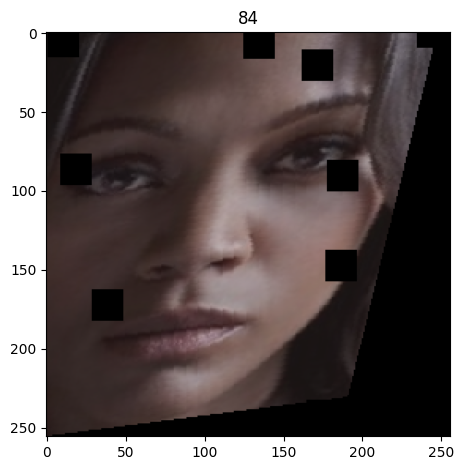

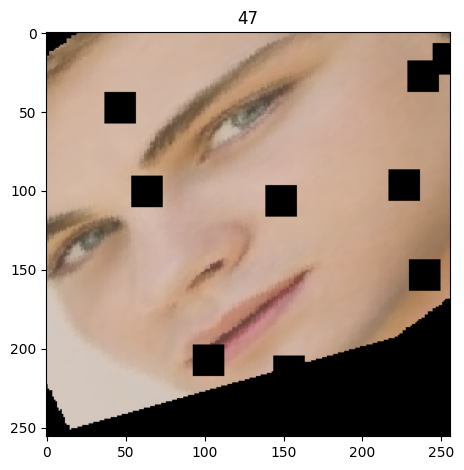

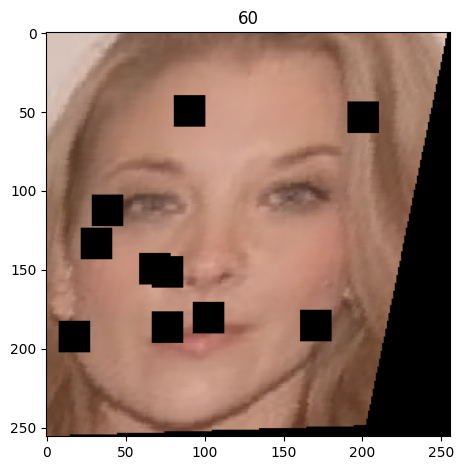

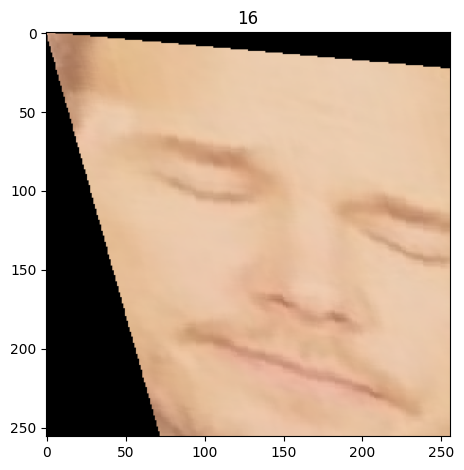

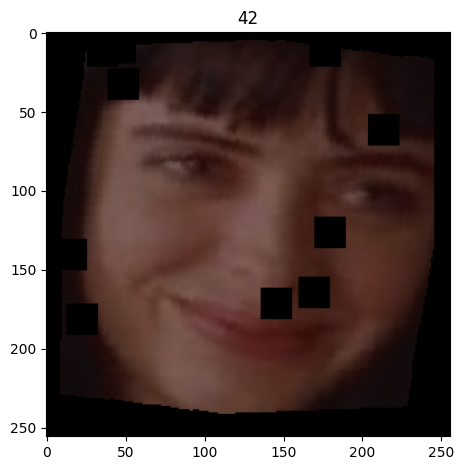

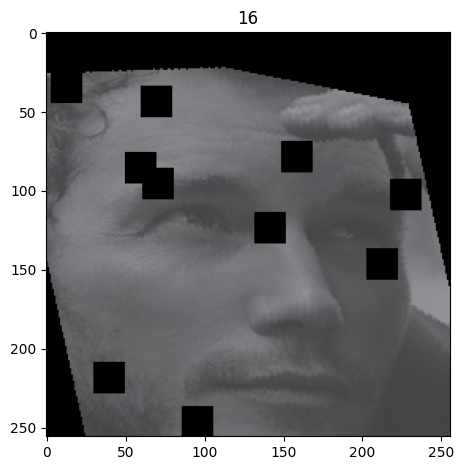

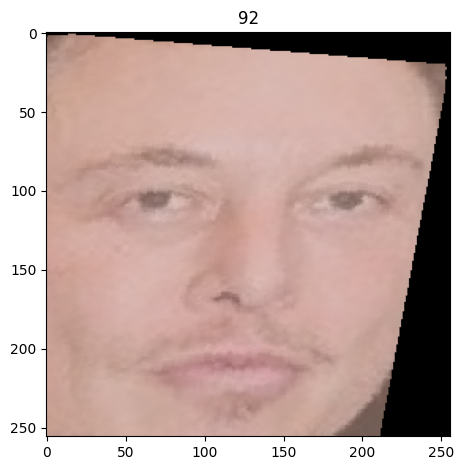

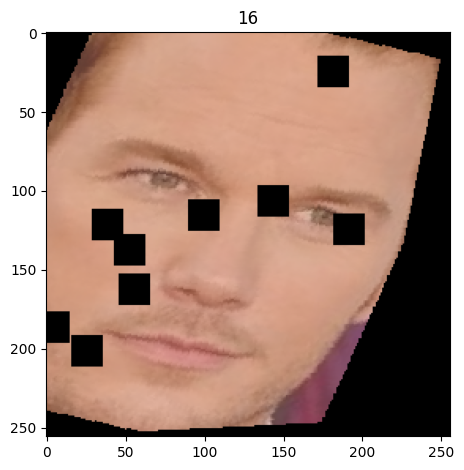

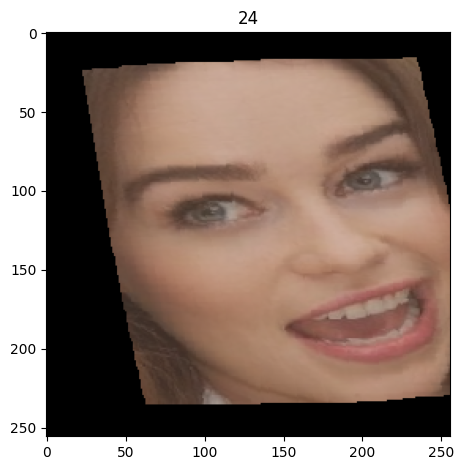

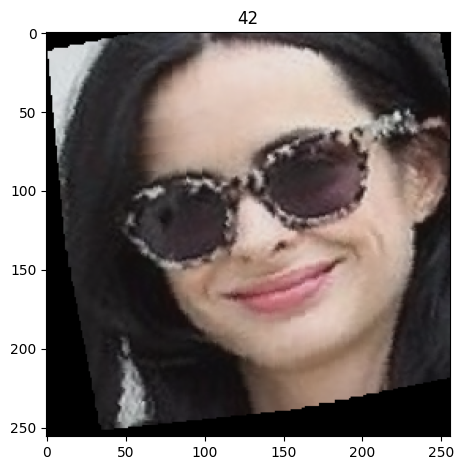

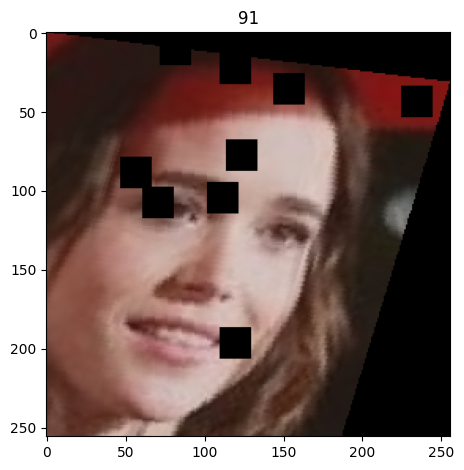

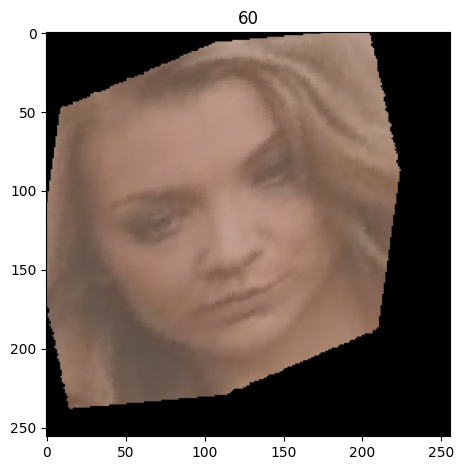

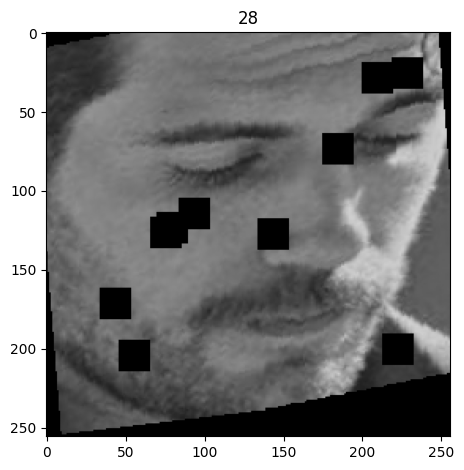

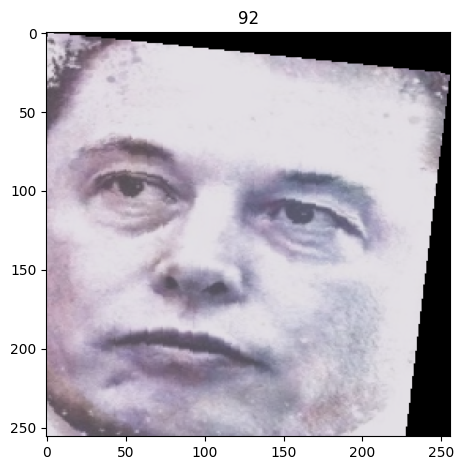

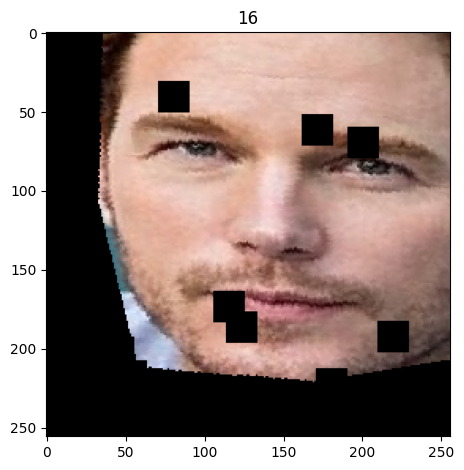

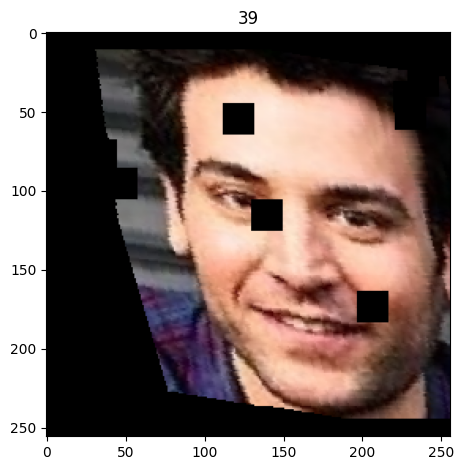

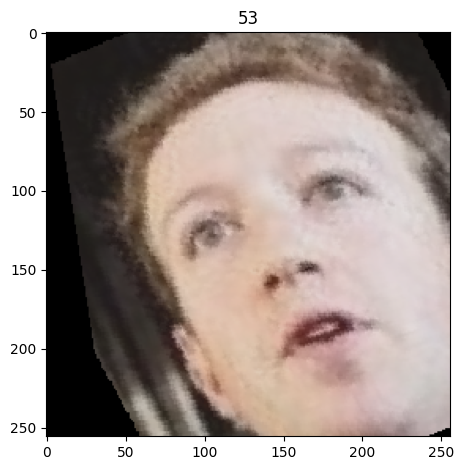

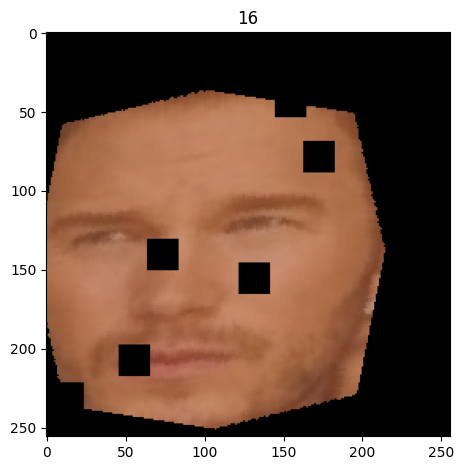

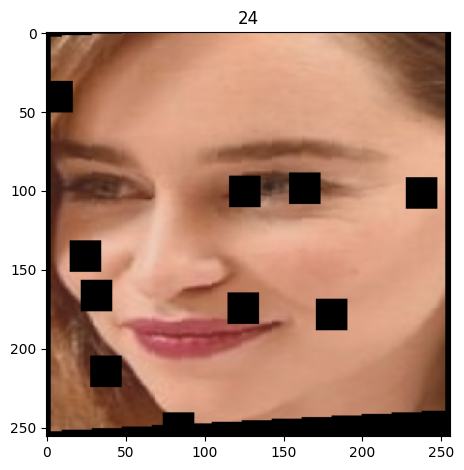

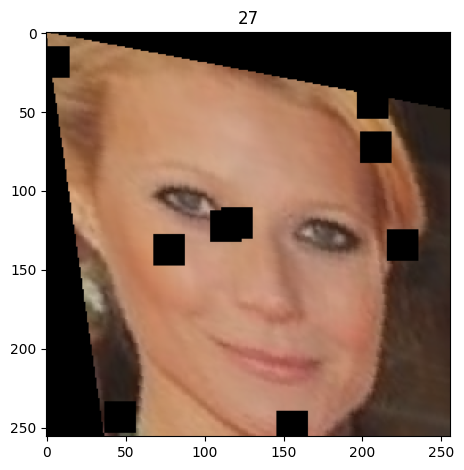

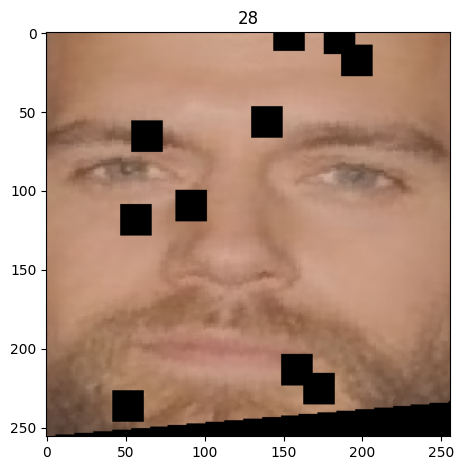

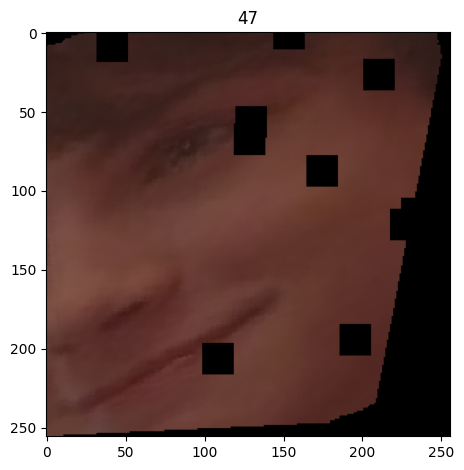

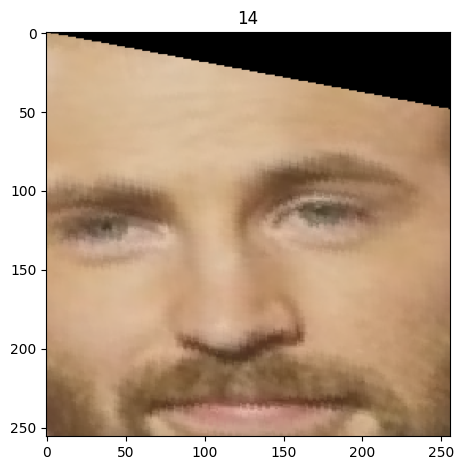

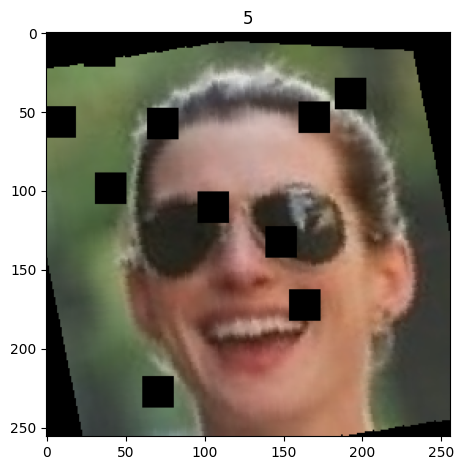

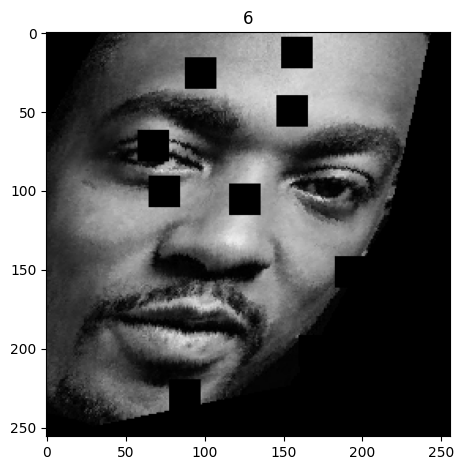

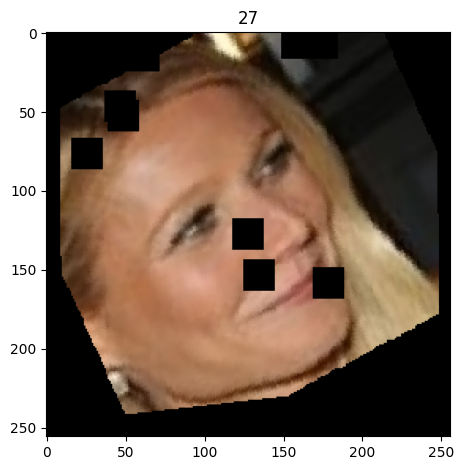

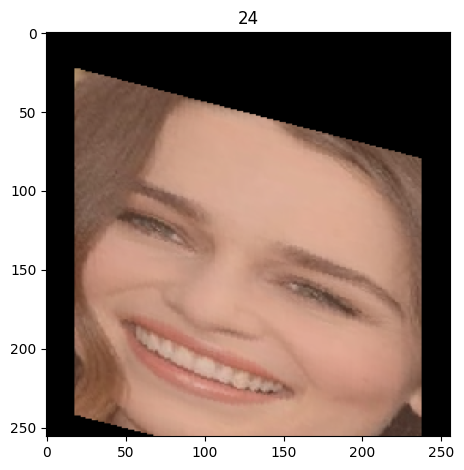

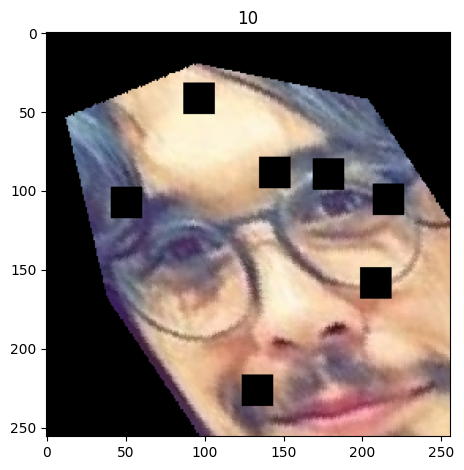

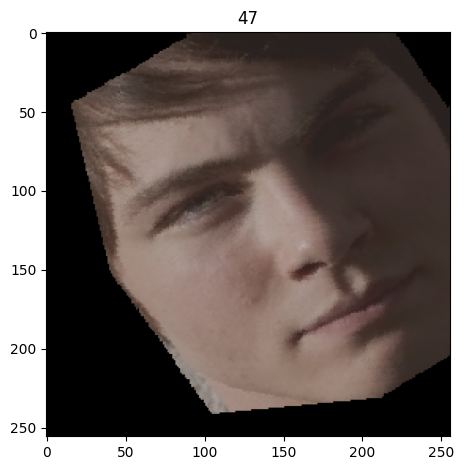

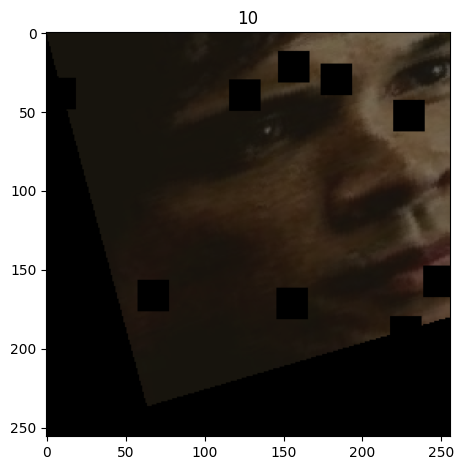

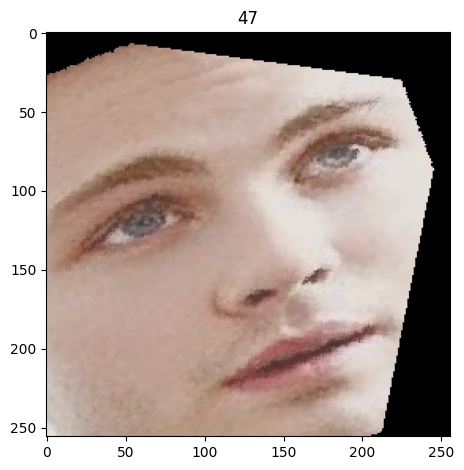

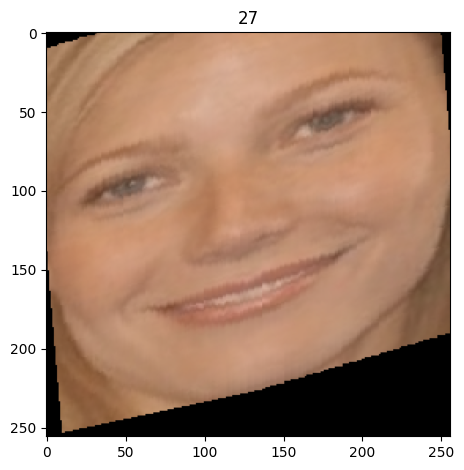

In [19]:
for i in range(32):
    img=images[i,...].numpy()
    plt.imshow(img)
    plt.title(labels[i].numpy())
    plt.tight_layout()
    plt.show()

Experimentation:

1) Dense layer Yes/No

2) m value change from 0.2 to 0.8

3) Gradual increase of m during training


In [20]:
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2L
from tensorflow.keras.applications import DenseNet201
import math

In [21]:
class ArcFace(tf.keras.layers.Layer):
    def __init__(self,m,s,n_classes):
        super().__init__()
        self.m=m
        self.s=s
        self.classes=n_classes
        self.cos_m=tf.math.cos(m)
        self.sin_m=tf.math.sin(m)
        self.threshold=tf.math.cos(math.pi-m)
        self.mm=tf.math.sin(math.pi-m)*m
    
    def build(self,input_shape):
        prev=input_shape[0][-1]
        self.w=self.add_weight(shape=(prev,self.classes),initializer='glorot_uniform',trainable=True,dtype=tf.float32)
    
    def call(self,inputs):
        x,y=inputs
        norm_x=tf.linalg.l2_normalize(x,axis=-1)
        norm_w=tf.linalg.l2_normalize(self.w,axis=0)
        cosine=tf.linalg.matmul(norm_x,norm_w)
        sin_theta=tf.sqrt(1.0-tf.square(cosine))
        y_one_hot=tf.cast(tf.one_hot(y,self.classes),dtype=tf.float32)
        cos_theta_m=(self.cos_m*cosine)-(self.sin_m*sin_theta)    
        cos_theta_m=tf.where(cosine>self.threshold,cos_theta_m,cosine-self.mm)
        final=(y_one_hot*cos_theta_m)+((1-y_one_hot)*cosine)
        final=self.s*final
        return final

In [22]:
def LR_Callback(epoch):
    min_lr=0.00001
    max_lr=0.00005*strategy.num_replicas_in_sync
    if epoch<7:
        lr=min_lr+(max_lr-min_lr)*(epoch/5)
    else:
        lr=min_lr+(max_lr-min_lr)*(0.8)**(epoch-5)
    return lr
    

In [23]:
for fold in range(5):
    train_folds=tf.io.gfile.glob(f"{GCS_DS_PATH}/TFRecords/pin_faces_fold_[!{fold}].tfrec")
    train_data=TFRecords_Dataset(train_folds,True,BATCH_SIZE)
    test_fold=tf.io.gfile.glob(f"{GCS_DS_PATH}/TFRecords/pin_faces_fold_[{fold}].tfrec")
    test_data=TFRecords_Dataset(test_fold,False,BATCH_SIZE)
    tf.keras.backend.clear_session()
    run=wandb.init(project="FaceRecognition-kfold",
                   config=CONFIG,
                   group=f"BatchNorm={CONFIG.get('BatchNorm')}&Units={CONFIG.get('Dense_neurons')}&m-varies",
                   job_type=f"m={CONFIG.get('m')}",
                   name=f"{CONFIG.get('model_name')}-run-fold-{fold}")
    with strategy.scope():
        m=run.config['m']
        s=run.config['s']
        arc_layer=ArcFace(m,s,N_CLASSES)
        pre_trained=DenseNet201(include_top=False,input_shape=(256,256,3))
        pre_trained.trainable=True
        Y=tf.keras.layers.Input(shape=(),dtype=tf.int32)
        x=tf.keras.layers.GlobalAveragePooling2D()(pre_trained.output)
        if run.config['BatchNorm']:
            print("batch norm applied")
            x=tf.keras.layers.BatchNormalization()(x)
        if run.config['isDense']:
            neurons=run.config['Dense_neurons']
            print(f"Dense layer is used with {neurons} units")
            x=tf.keras.layers.Dense(units=neurons)(x)
            x=tf.keras.layers.BatchNormalization()(x)
            x=tf.keras.layers.ReLU()(x)
        x=arc_layer((x,Y))
        output_layer=tf.keras.layers.Softmax()(x)
        model=tf.keras.models.Model(inputs=(pre_trained.input,Y),outputs=output_layer)
        model.compile(optimizer='Adam',loss=tf.keras.losses.SparseCategoricalCrossentropy())
        earlystopping=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=3,mode="min",restore_best_weights=True)
        lr_callback=tf.keras.callbacks.LearningRateScheduler(lambda epoch: LR_Callback(epoch),verbose=1)
        checkpointer=WandbCallback(monitor='val_loss',mode="min",save_weights_only=True,verbose=1)
    model.fit(train_data,validation_data=test_data,epochs=40,
              callbacks=[earlystopping,lr_callback,checkpointer],
             steps_per_epoch=STEPS_PER_EPOCH[fold],validation_steps=VALIDATION_STEPS[fold])
    run.finish()

wandb: Currently logged in as: raviteja_. Use `wandb login --relogin` to force relogin


74836368/74836368 [==============================] - 0s 0us/step
batch norm applied
Dense layer is used with 1024 units


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.
wandb: WARNING Unable to compute FLOPs for this model.



Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/40


2023-07-09 10:01:09.885087: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-07-09 10:01:12.629824: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


104/104 [==============================] - ETA: 0s - loss: 10.8678

2023-07-09 10:03:41.495260: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-07-09 10:03:42.099046: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


Epoch 00000: val_loss improved from inf to 10.80321, saving model to /kaggle/working/wandb/run-20230709_095836-cz1g6v4y/files/model-best.h5
104/104 [==============================] - 271s 670ms/step - loss: 10.8678 - val_loss: 10.8032 - lr: 1.0000e-05 - _timestamp: 1688897054.0000 - _runtime: 338.0000

Epoch 2: LearningRateScheduler setting learning rate to 8.8e-05.
Epoch 2/40
104/104 [==============================] - 35s 338ms/step - loss: 10.1679 - val_loss: 9.7095 - lr: 8.8000e-05 - _timestamp: 1688897090.0000 - _runtime: 374.0000

Epoch 3: LearningRateScheduler setting learning rate to 0.000166.
Epoch 3/40
104/104 [==============================] - 39s 377ms/step - loss: 8.7413 - val_loss: 7.9584 - lr: 1.6600e-04 - _timestamp: 1688897129.0000 - _runtime: 413.0000

Epoch 4: LearningRateScheduler setting learning rate to 0.000244.
Epoch 4/40
104/104 [==============================] - 35s 334ms/step - loss: 6.9598 - val_loss: 6.3977 - lr: 2.4400e-04 - _timestamp: 1688897163.0000 - _r

batch norm applied
Dense layer is used with 1024 units


wandb: WARNING Unable to compute FLOPs for this model.



Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/40


2023-07-09 10:22:22.097698: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-07-09 10:22:24.737037: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


104/104 [==============================] - ETA: 0s - loss: 10.8740

2023-07-09 10:23:03.559469: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-07-09 10:23:04.194371: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


Epoch 00000: val_loss improved from inf to 10.86901, saving model to /kaggle/working/wandb/run-20230709_102006-2gne493h/files/model-best.h5
104/104 [==============================] - 141s 444ms/step - loss: 10.8740 - val_loss: 10.8690 - lr: 1.0000e-05 - _timestamp: 1688898193.0000 - _runtime: 187.0000

Epoch 2: LearningRateScheduler setting learning rate to 8.8e-05.
Epoch 2/40
104/104 [==============================] - 35s 338ms/step - loss: 10.1931 - val_loss: 9.7783 - lr: 8.8000e-05 - _timestamp: 1688898228.0000 - _runtime: 222.0000

Epoch 3: LearningRateScheduler setting learning rate to 0.000166.
Epoch 3/40
104/104 [==============================] - 36s 344ms/step - loss: 8.7791 - val_loss: 8.0382 - lr: 1.6600e-04 - _timestamp: 1688898264.0000 - _runtime: 258.0000

Epoch 4: LearningRateScheduler setting learning rate to 0.000244.
Epoch 4/40
104/104 [==============================] - 38s 369ms/step - loss: 6.9538 - val_loss: 7.1870 - lr: 2.4400e-04 - _timestamp: 1688898302.0000 - _r

batch norm applied
Dense layer is used with 1024 units


wandb: WARNING Unable to compute FLOPs for this model.



Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/40


2023-07-09 10:42:41.748837: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-07-09 10:42:44.569063: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


104/104 [==============================] - ETA: 0s - loss: 10.8520

2023-07-09 10:43:22.792377: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-07-09 10:43:23.376109: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


Epoch 00000: val_loss improved from inf to 10.85609, saving model to /kaggle/working/wandb/run-20230709_104023-3p8m5fyu/files/model-best.h5
104/104 [==============================] - 141s 443ms/step - loss: 10.8520 - val_loss: 10.8561 - lr: 1.0000e-05 - _timestamp: 1688899413.0000 - _runtime: 190.0000

Epoch 2: LearningRateScheduler setting learning rate to 8.8e-05.
Epoch 2/40
104/104 [==============================] - 36s 342ms/step - loss: 10.1860 - val_loss: 9.6997 - lr: 8.8000e-05 - _timestamp: 1688899448.0000 - _runtime: 225.0000

Epoch 3: LearningRateScheduler setting learning rate to 0.000166.
Epoch 3/40
104/104 [==============================] - 35s 339ms/step - loss: 8.8092 - val_loss: 8.0135 - lr: 1.6600e-04 - _timestamp: 1688899483.0000 - _runtime: 260.0000

Epoch 4: LearningRateScheduler setting learning rate to 0.000244.
Epoch 4/40
104/104 [==============================] - 38s 366ms/step - loss: 7.0635 - val_loss: 7.1196 - lr: 2.4400e-04 - _timestamp: 1688899521.0000 - _r

batch norm applied
Dense layer is used with 1024 units


wandb: WARNING Unable to compute FLOPs for this model.



Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/40


2023-07-09 11:05:21.880095: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-07-09 11:05:24.869074: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


104/104 [==============================] - ETA: 0s - loss: 10.8842

2023-07-09 11:06:03.891893: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-07-09 11:06:04.483406: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


Epoch 00000: val_loss improved from inf to 10.86401, saving model to /kaggle/working/wandb/run-20230709_110303-3azf9wo5/files/model-best.h5
104/104 [==============================] - 143s 446ms/step - loss: 10.8842 - val_loss: 10.8640 - lr: 1.0000e-05 - _timestamp: 1688900773.0000 - _runtime: 190.0000

Epoch 2: LearningRateScheduler setting learning rate to 8.8e-05.
Epoch 2/40
104/104 [==============================] - 36s 345ms/step - loss: 10.2045 - val_loss: 9.7455 - lr: 8.8000e-05 - _timestamp: 1688900809.0000 - _runtime: 226.0000

Epoch 3: LearningRateScheduler setting learning rate to 0.000166.
Epoch 3/40
104/104 [==============================] - 36s 346ms/step - loss: 8.7671 - val_loss: 7.9118 - lr: 1.6600e-04 - _timestamp: 1688900845.0000 - _runtime: 262.0000

Epoch 4: LearningRateScheduler setting learning rate to 0.000244.
Epoch 4/40
104/104 [==============================] - 38s 365ms/step - loss: 6.9475 - val_loss: 6.1846 - lr: 2.4400e-04 - _timestamp: 1688900883.0000 - _r

batch norm applied
Dense layer is used with 1024 units


wandb: WARNING Unable to compute FLOPs for this model.



Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/40


2023-07-09 11:26:53.356960: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-07-09 11:26:56.531094: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


104/104 [==============================] - ETA: 0s - loss: 10.9132

2023-07-09 11:27:36.199250: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-07-09 11:27:36.839765: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


Epoch 00000: val_loss improved from inf to 10.83006, saving model to /kaggle/working/wandb/run-20230709_112432-2kzaa2t3/files/model-best.h5
104/104 [==============================] - 146s 446ms/step - loss: 10.9132 - val_loss: 10.8301 - lr: 1.0000e-05 - _timestamp: 1688902066.0000 - _runtime: 193.0000

Epoch 2: LearningRateScheduler setting learning rate to 8.8e-05.
Epoch 2/40
104/104 [==============================] - 36s 346ms/step - loss: 10.2385 - val_loss: 9.9348 - lr: 8.8000e-05 - _timestamp: 1688902101.0000 - _runtime: 228.0000

Epoch 3: LearningRateScheduler setting learning rate to 0.000166.
Epoch 3/40
104/104 [==============================] - 36s 343ms/step - loss: 8.8252 - val_loss: 7.9452 - lr: 1.6600e-04 - _timestamp: 1688902137.0000 - _runtime: 264.0000

Epoch 4: LearningRateScheduler setting learning rate to 0.000244.
Epoch 4/40
104/104 [==============================] - 38s 363ms/step - loss: 7.0576 - val_loss: 6.6378 - lr: 2.4400e-04 - _timestamp: 1688902175.0000 - _r